In [1]:
# Google Driveのマウント
from google.colab import drive, files
drive.mount('/content/drive') # , force_remount=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install omegaconf
# !pip install gymnasium
!pip install gymnasium-robotics
# !pip install wandb

In [5]:
#config.py
from dataclasses import dataclass


@dataclass
class WorldModelConfig:
    emb_dim: int = 1024
    z_dim: int = 32
    num_classes: int = 32
    h_dim: int = 600
    hidden_dim: int = 600
    num_layers_za2hidden: int = 1
    num_layers_h2z: int = 1
    mlp_hidden_dim: int = 400
    min_std: float = 0.1
    kl_balance_alpha: float = 0.8
    kl_loss_scale: float = 0.1


@dataclass
class ExplorerConfig:
    num_emsembles: int = 10
    emsembles_offset: int = 1
    emsembles_target_mode: str = 'z'
    mlp_hidden_dim: int = 400
    min_std: float = 0.1
    discount: float = 0.99
    lambda_: float = 0.95
    actor_entropy_scale: float = 1e-4
    slow_critic_update: int = 100


@dataclass
class AchieverConfig:
    num_positives: int = 256
    neg_sampling_factor: int = 0.1
    mlp_hidden_dim: int = 400
    min_std: float = 0.1
    discount: float = 0.99
    lambda_: float = 0.95
    actor_entropy_scale: float = 1e-4
    slow_critic_update: int = 100


@dataclass
class LEXAModelConfig:
    world_model: WorldModelConfig = WorldModelConfig()
    explorer: ExplorerConfig = ExplorerConfig()
    achiever: AchieverConfig = AchieverConfig()


@dataclass
class DataConfig:
    buffer_size: int = 2e6
    batch_size: int = 50
    seq_length: int = 50
    imagination_horizon: int = 15


@dataclass
class LearningConfig:
    seed_steps: int = 5000
    num_steps: int = 1e7
    expl_episode_freq: int = 2
    world_model_lr: float = 2e-4
    explorer_actor_lr: float = 4e-5
    explorer_critic_lr: float = 1e-4
    achiever_actor_lr: float = 4e-5
    achiever_critic_lr: float = 1e-4
    epsilon: float = 1e-5
    weight_decay: float = 1e-6
    grad_clip: float = 100
    update_freq: int = 4
    eval_episode_freq: int = 5


@dataclass
class EnvConfig:
    task: str = 'FrankaKitchen-v1'
    img_size: int = 128
    action_repeat: int = 2
    time_limit: int = 1000


@dataclass
class WandbConfig:
    logging: bool = False
    name: str = 'lexa'
    group: str = ''
    project: str = 'LEXA'


@dataclass
class Config:
    model: LEXAModelConfig = LEXAModelConfig()
    env: EnvConfig = EnvConfig()
    data: DataConfig = DataConfig()
    learning: LearningConfig = LearningConfig()
    wandb: WandbConfig = WandbConfig()
    device: str = 'cuda'
    seed: int = 0


### model

In [6]:
#model.utils.py

import numpy as np
from PIL import Image
import torch
import torch.distributions as td
from torch.distributions.utils import _standard_normal
from einops import rearrange


class TruncatedNormal(td.Normal):
    def __init__(self, loc: torch.Tensor, scale: torch.Tensor, low: float = -1.0, high: float = 1.0, eps: float = 1e-6) -> None:
        super().__init__(loc, scale, validate_args=False)
        self.low = low
        self.high = high
        self.eps = eps

    def _clamp(self, x: torch.Tensor) -> torch.Tensor:
        clamped_x = torch.clamp(x, self.low + self.eps, self.high - self.eps)
        x = x - x.detach() + clamped_x.detach()
        return x

    def sample(self, clip: float | None = None, sample_shape: torch.Size = torch.Size()) -> torch.Tensor:
        shape = self._extended_shape(sample_shape)
        eps = _standard_normal(shape, dtype=self.loc.dtype, device=self.loc.device)

        eps *= self.scale
        if clip is not None:
            eps = torch.clamp(eps, -clip, clip)
        x = self.loc + eps
        return self._clamp(x)


def compute_lambda_target(rewards: torch.Tensor, discount: float, values: torch.Tensor, lambda_: float):
    V_lambda = torch.zeros_like(rewards)

    for t in reversed(range(rewards.shape[0])):
        if t == rewards.shape[0] - 1:
            V_lambda[t] = rewards[t] + discount * values[t]
        else:
            V_lambda[t] = rewards[t] + discount * ((1-lambda_) * values[t+1] + lambda_ * V_lambda[t+1])

    return V_lambda


In [7]:
#network.py

from typing import Literal
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal, OneHotCategoricalStraightThrough, Independent, Bernoulli

# from .utils import TruncatedNormal


class RSSM(nn.Module):
    def __init__(self,
                 z_dim=30,
                 num_classes=20,
                 h_dim=200,
                 hidden_dim=200,
                 emb_dim=32,
                 action_dim=9,
                 num_layers_za2hidden=1,
                 num_layers_h2z=1,
                 min_std=0.1):
        super(RSSM, self).__init__()

        self.z_dim = z_dim
        self.h_dim = h_dim
        self.hidden_dim = hidden_dim
        self.emb_dim = emb_dim
        self.action_dim = action_dim
        self.num_layers_za2hidden = num_layers_za2hidden
        self.num_layers_h2z = num_layers_h2z
        self.num_classes = num_classes
        self.min_std = min_std

        self.za2hidden = nn.Sequential(
            *([nn.Sequential(nn.Linear(self.z_dim + self.action_dim, self.hidden_dim), nn.ELU())] + \
            [nn.Sequential(nn.Linear(self.hidden_dim, self.hidden_dim), nn.ELU()) for _ in range(self.num_layers_za2hidden - 1)])
        )
        self.transition = nn.GRUCell(self.hidden_dim, self.h_dim)

        self.prior_hidden = nn.Sequential(
            *([nn.Sequential(nn.Linear(self.h_dim, self.hidden_dim), nn.ELU())] + \
            [nn.Sequential(nn.Linear(self.hidden_dim, self.hidden_dim), nn.ELU()) for _ in range(self.num_layers_h2z - 1)])
        )
        self.prior_logits = nn.Linear(self.hidden_dim, self.z_dim * self.num_classes)

        self.posterior_hidden = nn.Sequential(
            *([nn.Sequential(nn.Linear(self.h_dim + self.emb_dim, self.hidden_dim), nn.ELU())] + \
            [nn.Sequential(nn.Linear(self.hidden_dim, self.hidden_dim), nn.ELU()) for _ in range(self.num_layers_h2z - 1)])
        )
        self.posterior_logits = nn.Linear(self.hidden_dim, self.z_dim * self.num_classes)

    def recurrent(self, z, action, h):
        hidden = self.za2hidden(torch.concat([z, action], dim=1))
        next_h = self.transition(hidden, h)
        return next_h

    def prior(self, h, detach=False):
        hidden = self.prior_hidden(h)
        logits = self.prior_logits(hidden)
        logits = logits.reshape(logits.shape[0], self.z_dim, self.num_classes)
        prior = Independent(OneHotCategoricalStraightThrough(logits=logits), 1)
        if detach:
            detach_prior = Independent(OneHotCategoricalStraightThrough(logits=logits.detach()), 1)
            return prior, detach_prior
        return prior

    def posterior(self, h, emb, detach=False):
        hidden = self.posterior_hidden(torch.concat([h, emb], dim=1))
        logits = self.posterior_logits(hidden)
        logits = logits.reshape(logits.shape[0], self.z_dim, self.num_classes)
        posterior = Independent(OneHotCategoricalStraightThrough(logits=logits), 1)
        if detach:
            detach_posterior = Independent(OneHotCategoricalStraightThrough(logits=logits.detach()), 1)
            return posterior, detach_posterior
        return posterior


class ConvEncoder(nn.Module):
    def __init__(self, input_size, emb_dim):
        super(ConvEncoder, self).__init__()

        self.net = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
            nn.LayerNorm([32, input_size // 2, input_size // 2]),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.LayerNorm([64, input_size // 4, input_size // 4]),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.LayerNorm([128, input_size // 8, input_size // 8]),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.LayerNorm([256, input_size // 16, input_size // 16]),
            nn.ReLU(),
        )

        self.fc = nn.Linear((input_size // 16) ** 2 * 256 , emb_dim)

    def forward(self, x):
        x = self.net(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        return x


class ConvDecoder(nn.Module):
    def __init__(self, img_size, z_dim, num_classes, h_dim):
        super(ConvDecoder, self).__init__()

        self.img_size = img_size
        self.fc = nn.Sequential(
            nn.Linear(z_dim * num_classes + h_dim, (img_size // 16) ** 2 * 256),
            nn.LayerNorm([(img_size // 16) ** 2 * 256,]),
            nn.ReLU()
        )
        self.net = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.LayerNorm([128, img_size // 8, img_size // 8]),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.LayerNorm([64, img_size // 4, img_size // 4]),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.LayerNorm([32, img_size // 2, img_size // 2]),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
        )

    def forward(self, z, h):
        x = torch.concat([z, h], dim=1)
        out = self.fc(x)
        out = out.reshape(out.shape[0], 256, self.img_size // 16, self.img_size // 16)
        out = self.net(out)
        dist = Independent(Normal(out, 1), 3)
        return dist


class Discount(nn.Module):
    def __init__(self, z_dim, num_classes, h_dim, hidden_dim=256):
        super(Discount, self).__init__()

        self.z_dim = z_dim
        self.num_classes = num_classes
        self.h_dim = h_dim
        self.hidden_dim = hidden_dim

        self.net = nn.Sequential(
            nn.Linear(z_dim * num_classes + h_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(self.hidden_dim * 2, self.hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, 1),
        )

    def forward(self, z, h):
        logits = self.net(torch.concat([z, h], dim=1))
        dist = Independent(Bernoulli(logits=logits), 1)
        return dist


class ExprolerStatePredictor(nn.Module):
    def __init__(self, z_dim, num_classes, h_dim, target_dim, min_std, hidden_dim=256):
        super(ExprolerStatePredictor, self).__init__()

        self.z_dim = z_dim
        self.num_classes = num_classes
        self.h_dim = h_dim
        self.min_std = min_std
        self.hidden_dim = hidden_dim
        self.target_dim = target_dim

        self.net = nn.Sequential(
            nn.Linear(z_dim * num_classes + h_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
        )
        self.mean_fc = nn.Linear(hidden_dim, target_dim)
        self.std_fc = nn.Linear(hidden_dim, target_dim)

    def forward(self, z, h):
        h = self.net(torch.concat([z, h], dim=1))
        mean = self.mean_fc(h)
        std = self.std_fc(h) + self.min_std
        return Independent(Normal(mean, std), 1)


class ExplorerActor(nn.Module):
    def __init__(self, action_dim, z_dim, num_classes, h_dim, hidden_dim=256, min_std=0.1):
        super(ExplorerActor, self).__init__()

        self.action_dim = action_dim
        self.z_dim = z_dim
        self.num_classes = num_classes
        self.h_dim = h_dim
        self.hidden_dim = hidden_dim
        self.min_std = min_std

        self.net = nn.Sequential(
            nn.Linear(z_dim * num_classes + h_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
        )
        self.mean_fc = nn.Linear(hidden_dim, action_dim)
        self.std_fc = nn.Linear(hidden_dim, action_dim)

    def forward(self, z, h, train=True):
        h = self.net(torch.concat([z, h], dim=1))
        mean = F.tanh(self.mean_fc(h))
        std = 2 * F.sigmoid(self.std_fc(h) / 2) + self.min_std
        dist = Independent(TruncatedNormal(mean, std, -1, 1), 1)
        if train:
            action = dist.rsample()
            log_prob = dist.log_prob(action.detach())
            entropy = dist.entropy()
            return action, log_prob, entropy
        else:
            action = dist.mean
            return action, None, None


class ExplorerCritic(nn.Module):
    def __init__(self, z_dim, num_classes, h_dim, hidden_dim=256):
        super(ExplorerCritic, self).__init__()

        self.z_dim = z_dim
        self.z_dim = z_dim
        self.num_classes = num_classes
        self.h_dim = h_dim
        self.hidden_dim = hidden_dim

        self.net = nn.Sequential(
            nn.Linear(z_dim * num_classes + h_dim, self.hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, 1),
        )

    def forward(self, z, h):
        return self.net(torch.concat([z, h]), dim=1)


class State2Emb(nn.Module):
    def __init__(self, z_dim, num_classes, h_dim, emb_dim, hidden_dim=256):
        super(State2Emb, self).__init__()

        self.z_dim = z_dim
        self.num_classes = num_classes
        self.h_dim = h_dim
        self.emb_dim = emb_dim
        self.hidden_dim = hidden_dim

        self.net = nn.Sequential(
            nn.Linear(z_dim * num_classes + h_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
        )
        self.mean_fc = nn.Linear(hidden_dim, emb_dim)
        self.std_fc = nn.Linear(hidden_dim, emb_dim)

    def forward(self, z, h):
        h = self.net(torch.concat([z, h], dim=1))
        mean = self.mean_fc(h)
        std = self.std_fc(h)
        return Independent(Normal(mean, std), 1)


class AchieverDistanceEstimator(nn.Module):
    def __init__(self, emb_dim, hidden_dim=256):
        super(AchieverDistanceEstimator, self).__init__()

        self.emb_dim = emb_dim
        self.hidden_dim = hidden_dim

        self.state2emb = nn

        self.current_fc = nn.Sequential(nn.Linear(emb_dim, hidden_dim),
                                        nn.GELU())
        self.goal_fc = nn.Sequential(nn.Linear(emb_dim, hidden_dim),
                                     nn.GELU())
        self.net = nn.Sequential(
            nn.Linear(self.hidden_dim * 2, self.hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, current_emb, goal_emb):
        cur_h = self.current_fc(current_emb)
        goal_h = self.goal_fc(goal_emb)
        return self.net(torch.concat([cur_h, goal_h]), dim=1)


class AchieverCritic(nn.Module):
    def __init__(self, z_dim, num_classes, h_dim, emb_dim, hidden_dim=256):
        super(AchieverCritic, self).__init__()

        self.z_dim = z_dim
        self.num_classes = num_classes
        self.h_dim = h_dim
        self.emb_dim = emb_dim
        self.hidden_dim = hidden_dim

        self.state_fc = nn.Sequential(nn.Linear(z_dim * num_classes + h_dim, hidden_dim),
                                      nn.GELU())
        self.goal_fc = nn.Sequential(nn.Linear(emb_dim, hidden_dim),
                                     nn.GELU())
        self.net = nn.Sequential(
            nn.Linear(self.hidden_dim * 2, self.hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, 1),
        )

    def forward(self, z, h, goal_emb):
        state_h = self.state_fc(torch.concat([z, h]), dim=1)
        goal_h = self.goal_fc(goal_emb)
        return self.net(torch.concat([state_h, goal_h]), dim=1)


class AchieverActor(nn.Module):
    def __init__(self, action_dim, z_dim, num_classes, h_dim, emb_dim, hidden_dim=256, min_std=0.1):
        super(AchieverActor, self).__init__()

        self.action_dim = action_dim
        self.z_dim = z_dim
        self.num_classes = num_classes
        self.h_dim = h_dim
        self.emb_dim = emb_dim
        self.hidden_dim = hidden_dim
        self.min_std = min_std

        self.state_fc = nn.Sequential(nn.Linear(z_dim * num_classes + h_dim, hidden_dim),
                                      nn.GELU())
        self.goal_fc = nn.Sequential(nn.Linear(emb_dim, hidden_dim),
                                     nn.GELU())
        self.net = nn.Sequential(
            nn.Linear(self.hidden_dim * 2, self.hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
        )
        self.mean_fc = nn.Linear(hidden_dim, action_dim)
        self.std_fc = nn.Linear(hidden_dim, action_dim)

    def forward(self, z, h, goal_emb, train=True):
        state_h = self.state_fc(torch.concat([z, h], dim=1))
        goal_h = self.goal_fc(goal_emb)
        h = self.net(torch.concat([state_h, goal_h], dim=1))
        mean = F.tanh(self.mean_fc(h))
        std = 2 * F.sigmoid(self.std_fc(h) / 2) + self.min_std
        dist = Independent(TruncatedNormal(mean, std, -1, 1), 1)
        if train:
            action = dist.rsample()
            log_prob = dist.log_prob(action.detach())
            entropy = dist.entropy()
            return action, log_prob, entropy
        else:
            action = dist.mean
        return action, None, None


In [8]:
#worldmodel.py
from collections import OrderedDict
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import kl_divergence
from einops import rearrange

# from .network import RSSM, ConvEncoder, ConvDecoder, Discount


class WorldModel(nn.Module):
    def __init__(self,
                 img_size,
                 emb_dim,
                 action_dim,
                 z_dim,
                 num_classes,
                 h_dim,
                 hidden_dim,
                 num_layers_za2hidden,
                 num_layers_h2z,
                 mlp_hidden_dim,
                 min_std,
                 kl_balance_alpha,
                 kl_loss_scale,
                 device):
        super(WorldModel, self).__init__()

        self.img_size = img_size
        self.action_dim = action_dim
        self.z_dim = z_dim
        self.num_classes = num_classes
        self.h_dim = h_dim
        self.hidden_dim = hidden_dim
        self.emb_dim = emb_dim
        self.num_layers_za2hidden = num_layers_za2hidden
        self.num_layers_h2z = num_layers_h2z
        self.mlp_hidden_dim = mlp_hidden_dim
        self.min_std = min_std
        self.kl_balance_alpha = kl_balance_alpha
        self.kl_loss_scale = kl_loss_scale
        self.device = device

        self.rssm = RSSM(
            z_dim = z_dim,
            num_classes = num_classes,
            h_dim = h_dim,
            hidden_dim = hidden_dim,
            emb_dim = emb_dim,
            action_dim = action_dim,
            num_layers_za2hidden = num_layers_za2hidden,
            num_layers_h2z = num_layers_h2z,
            min_std = min_std
        )
        self.encoder = ConvEncoder(
            input_size = img_size,
            emb_dim = emb_dim
        )
        self.decoder = ConvDecoder(
            img_size = img_size,
            z_dim = z_dim,
            num_classes = num_classes,
            h_dim = h_dim
        )

    def train(self, observations, actions):
        batch_size, seq_length, *_ = observations.shape
        observations = rearrange(observations, 'b t c h w -> t b c h w')
        actions = rearrange(actions, 'b t d -> t b d')

        embs = self.encoder(rearrange(observations, 't b c h w -> (t b) c h w'))
        embs = rearrange(embs, '(t b) d -> t b d')

        z = torch.zeros(batch_size, self.z_dim*self.num_classes, device=self.device)
        h = torch.zeros(batch_size, self.h_dim, device=self.device)

        zs = torch.empty(seq_length - 1, batch_size, self.z_dim*self.num_classes, device=self.device)
        hs = torch.empty(seq_length - 1, batch_size, self.h_dim, device=self.device)

        kl_loss = 0
        for t in range(seq_length - 1):
            h = self.rssm.recurrent(z, actions[t], h)
            next_prior, detach_next_prior = self.rssm.prior(h, detach=True)
            next_posterior, detach_next_posterior = self.rssm.posterior(h, embs[t+1], detach=True)
            z = next_posterior.rsample().flatten(1)
            hs[t] = h
            zs[t] = z
            kl_loss += self.kl_balance_alpha * torch.mean(kl_divergence(detach_next_posterior, next_prior)) + \
                       (1 - self.kl_balance_alpha) * torch.mean(kl_divergence(next_posterior, detach_next_prior))
        kl_loss = kl_loss / (seq_length - 1)

        flatten_hs = hs.view(-1, self.h_dim)
        flatten_zs = zs.view(-1, self.z_dim * self.num_classes)

        obs_dist = self.decoder(flatten_zs, flatten_hs)

        obs_loss = -torch.mean(obs_dist.log_prob(rearrange(observations[1:], 't b c h w -> (t b) c h w')))

        wm_loss = obs_loss + self.kl_loss_scale * kl_loss
        return wm_loss, (zs, hs), OrderedDict(wm_loss=wm_loss.item(), obs_loss=obs_loss.item(), kl_loss=kl_loss.item())

    def imagine(self, action, z, h):
        next_h = self.rssm.recurrent(z, action, h)
        next_prior = self.rssm.prior(next_h)
        next_z = next_prior.rsample().flatten(1)
        return next_h, next_z


In [9]:
#achiever_reward.py

from typing import Literal
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange

# from .network import AchieverDistanceEstimator, State2Emb


class LatentDistanceReward(nn.Module):
    def __init__(self,
                 z_dim,
                 num_classes,
                 h_dim,
                 emb_dim,
                 mlp_hidden_dim,
                 device):
        super(LatentDistanceReward, self).__init__()

        self.z_dim = z_dim
        self.num_classes = num_classes
        self.h_dim = h_dim
        self.emb_dim = emb_dim
        self.mlp_hidden_dim = mlp_hidden_dim
        self.device = device

        self.state2emb = State2Emb(
            z_dim = z_dim,
            num_classes = num_classes,
            h_dim = h_dim,
            emb_dim = emb_dim,
            hidden_dim = mlp_hidden_dim
        )

        self.distance_estimator = AchieverDistanceEstimator(
            emb_dim = emb_dim,
            hidden_dim = mlp_hidden_dim
        )

    def imagine_compute_reward(self, current_z, current_h, goal_z, goal_h):
        current_emb = self.state2emb(current_z, current_h)
        goal_emb = self.state2emb(goal_z, goal_h)
        distance = self.distance_estimator(current_emb, goal_emb)
        return -distance

    def compute_reward(self, z, h, goal_emb):
        current_emb = self.state2emb(z, h)
        distance = self.distance_estimator(current_emb, goal_emb)
        return -distance

    def train_state2emb(self, zs, hs, target_embs):
        embs_dist = self.state2emb(zs, hs)
        loss = -torch.mean(embs_dist.log_prob(target_embs))
        return loss

    def train_distance_estimator(self, zs, hs, num_positives, neg_sampling_factor, batch_length):
        def get_future_goal_idxs(seq_len, bs):
            cur_idx_list = []
            goal_idx_list = []
            for cur_idx in range(seq_len):
                for goal_idx in range(cur_idx, seq_len):
                    cur_idx_list.append(np.concatenate([np.ones((bs,1), dtype=np.int32)*cur_idx, np.arange(bs).reshape(-1,1)], axis = -1))
                    goal_idx_list.append(np.concatenate([np.ones((bs,1), dtype=np.int32)*goal_idx, np.arange(bs).reshape(-1,1)], axis = -1))

            return np.concatenate(cur_idx_list,0), np.concatenate(goal_idx_list,0)

        def get_future_goal_idxs_neg_sampling(num_negs, seq_len, bs):
            cur_idxs = np.random.randint((0,0), (seq_len, bs), size=(num_negs,2))
            goal_idxs = np.random.randint((0,0), (seq_len, bs), size=(num_negs,2))
            for i in range(num_negs):
                goal_idxs[i,1] = np.random.choice([j for j in range(bs) if j//batch_length != cur_idxs[i,1]//batch_length])
            return cur_idxs, goal_idxs

        zs, hs = zs.detach(), hs.detach()

        current_idxs, goal_idxs = get_future_goal_idxs(zs.shape[0], zs.shape[1])
        idx = np.random.choice(np.arange(len(current_idxs)), num_positives, replace=False)
        current_idx, goal_idx = current_idxs[idx], goal_idxs[idx]
        current_zs, current_hs = zs[current_idx[:,0], current_idx[:,1]], hs[current_idx[:,0], current_idx[:,1]]
        goal_zs, goal_hs = zs[goal_idx[:,0], goal_idx[:,1]], hs[goal_idx[:,0], goal_idx[:,1]]
        current_embs, goal_embs = self.state2emb(current_zs, current_hs).mean, self.state2emb(goal_zs, goal_hs).mean
        target_distance = (goal_idx[:,0] - current_idx[:,0]) / zs.shape[0]
        pred_distance = self.distance_estimator(current_embs, goal_embs)
        loss = F.mse_loss(pred_distance, target_distance)

        num_negatives = num_positives * neg_sampling_factor
        current_idx, goal_idx = get_future_goal_idxs_neg_sampling(num_negatives, zs.shape[0], zs.shape[1])
        current_zs, current_hs = zs[current_idx[:,0], current_idx[:,1]], hs[current_idx[:,0], current_idx[:,1]]
        goal_zs, goal_hs = zs[goal_idx[:,0], goal_idx[:,1]], hs[goal_idx[:,0], goal_idx[:,1]]
        current_embs, goal_embs = self.state2emb(current_zs, current_hs).mean, self.state2emb(goal_zs, goal_hs).mean
        target_distance = torch.ones(num_negatives, 1, device=self.device) * zs.shape[0]
        pred_distance = self.distance_estimator(current_embs, goal_embs)
        loss += F.mse_loss(pred_distance, target_distance)
        return loss


In [10]:
#achiever.py

from collections import OrderedDict
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as td
from einops import rearrange

# from .network import AchieverActor, AchieverCritic
# from .worldmodel import WorldModel
# from .achiever_reward import LatentDistanceReward
# from .utils import compute_lambda_target


class Achiever(nn.Module):
    def __init__(self,
                 world_model: WorldModel,
                 instrinsic_reward,
                 action_dim,
                 z_dim,
                 num_classes,
                 h_dim,
                 emb_dim,
                 mlp_hidden_dim,
                 min_std,
                 discount,
                 lambda_,
                 actor_entropy_scale,
                 device):
        super(Achiever, self).__init__()

        self.world_model = world_model

        self.action_dim = action_dim
        self.z_dim = z_dim
        self.num_classes = num_classes
        self.h_dim = h_dim
        self.mlp_hidden_dim = mlp_hidden_dim
        self.discount = discount
        self.lambda_ = lambda_
        self.actor_entropy_scale = actor_entropy_scale
        self.device = device

        self.actor = AchieverActor(
            action_dim = action_dim,
            z_dim = z_dim,
            num_classes = num_classes,
            h_dim = h_dim,
            emb_dim = emb_dim,
            hidden_dim = mlp_hidden_dim,
            min_std = min_std
        )
        self.critic = AchieverCritic(
            z_dim = z_dim,
            num_classes = num_classes,
            h_dim = h_dim,
            emb_dim = emb_dim,
            hidden_dim = mlp_hidden_dim
        )
        self.target_critic = AchieverCritic(
            z_dim = z_dim,
            num_classes = num_classes,
            h_dim = h_dim,
            emb_dim = emb_dim,
            hidden_dim = mlp_hidden_dim
        )
        self.target_critic.load_state_dict(self.critic.state_dict())

        self.instrinsic_reward = instrinsic_reward

    def train(self, init_zs: torch.Tensor, init_hs: torch.Tensor, goal_observations: torch.Tensor, horison_length, num_positives, neg_sampling_factor, batch_seq_length):
        goal_observations = rearrange(goal_observations, 'b t c h w -> (t b) c h w')
        shuffle_idx = torch.randperm(goal_observations.shape[0])
        goal_observations = goal_observations[shuffle_idx]
        goal_embs = self.world_model.encoder(goal_observations)

        zs = init_zs.detach() # (batch_size * seq_length, z_dim * num_classes)
        hs = init_hs.detach() # (batch_size * seq_length, h_dim)

        imagined_zs = torch.empty(horison_length, *init_zs.shape, device=self.device)
        imagined_hs = torch.empty(horison_length, *init_hs.shape, device=self.device)
        imagined_action_log_probs = torch.empty(horison_length, init_zs.shape[0], device=self.device)
        imagined_action_entropys = torch.empty(horison_length, init_zs.shape[0], device=self.device)

        for t in range(horison_length):
            actions, action_log_probs, action_entropys = self.actor(zs.detach(), hs.detach(), goal_embs)

            with torch.no_grad():
                hs, zs = self.world_model.imagine(actions, zs, hs)

            imagined_hs[t] = hs.detach()
            imagined_zs[t] = zs.detach()
            imagined_action_log_probs[t] = action_log_probs
            imagined_action_entropys[t] = action_entropys

        flatten_hs = imagined_hs.view(-1, self.h_dim).detach() # (horison_length * batch_size * seq_length, h_dim)
        flatten_zs = imagined_zs.view(-1, self.z_dim * self.num_classes).detach() # (horison_length * batch_size * seq_length, z_dim * num_classes)

        with torch.no_grad():
            rewards = self.instrinsic_reward.compute_reward(flatten_zs, flatten_hs, goal_embs).view(horison_length, -1) # (horison_length, batch_size * seq_length)
            target_values = self.target_critic(flatten_zs, flatten_hs, goal_embs).view(horison_length, -1) # (horison_length, batch_size * seq_length)

        lambda_target = compute_lambda_target(rewards, self.discount, target_values, self.lambda_)

        objective = imagined_action_log_probs * ((lambda_target - target_values).detach())
        actor_loss = -torch.sum(torch.mean(objective + self.actor_entropy_scale * imagined_action_entropys, dim=1))

        value_mean = self.critic(flatten_zs.detach(), flatten_hs.detach()).view(horison_length, -1)
        value_dist = td.Independent(td.Normal(value_mean, 1),  1)
        critic_loss = -torch.mean(value_dist.log_prob(lambda_target.detach()).unsqueeze(-1))

        distance_estimator_loss = self.instrinsic_reward.train_distance_estimator(imagined_zs, imagined_hs, num_positives, neg_sampling_factor, batch_seq_length)

        return actor_loss, critic_loss, distance_estimator_loss, OrderedDict(ach_actor_loss=actor_loss.item(), ach_critic_loss=critic_loss.item(), distance_estimator_loss=distance_estimator_loss.item())

    def update_critic(self):
        self.target_critic.load_state_dict(self.critic.state_dict())


In [11]:
#explorer_reward.py
from typing import Literal
from collections import OrderedDict
import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange

# from .network import ExprolerStatePredictor


class EmsembleReward(nn.Module):
    def __init__(self,
                 z_dim,
                 num_classes,
                 h_dim,
                 min_std,
                 mlp_hidden_dim,
                 device,
                 num_emsembles = 10,
                 offset = 1,
                 target_mode: Literal['z', 'h', 'zh'] = 'z'):
        super(EmsembleReward, self).__init__()

        self.z_dim = z_dim
        self.num_classes = num_classes
        self.h_dim = h_dim
        self.min_std = min_std
        self.num_emsembles = num_emsembles
        self.offset = offset
        self.target_mode = target_mode
        self.mlp_hidden_dim = mlp_hidden_dim
        self.device = device

        if target_mode == 'z':
            self.target_dim = z_dim * num_classes
        elif target_mode == 'h':
            self.target_dim = h_dim
        elif target_mode == 'zh':
            self.target_dim = z_dim * num_classes + h_dim

        self.emsembles = nn.ModuleList()
        for _ in range(num_emsembles):
            self.emsembles.append(
                ExprolerStatePredictor(
                    z_dim = z_dim,
                    num_classes = num_classes,
                    h_dim = h_dim,
                    min_std = min_std,
                    hidden_dim = mlp_hidden_dim,
                    target_dim = self.target_dim
                )
            )

    def compute_reward(self, z, h):
        input_ = torch.concat([z, h], dim=1)
        preds = torch.empty(self.num_emsembles, z.shape[0], self.target_dim, device=self.device)
        for n in range(self.num_emsembles):
            f = self.emsembles[n]
            preds[n] = f(input_).mean
        var = torch.std(preds, dim=0)
        reward = torch.sum(var, dim=1)
        return reward

    def train(self, zs, hs):
        input_ = torch.concat([zs, hs], dim=2)

        if self.target_mode == 'z':
            target = zs
        elif self.target_mode == 'h':
            target = hs
        elif self.target_mode == 'zh':
            target = input_

        input_ = rearrange(input_[:-self.offset].detach(), 't b d -> (t b) d')
        target = rearrange(input_[self.offset:].detach(), 't b d -> (t b) d')

        loss = 0
        for f in self.emsembles:
            dist = f(input_)
            loss += -torch.mean(dist.log_prob(target))
        return loss, OrderedDict(emsemble_loss=loss.item())



In [12]:
#explorer.py

from collections import OrderedDict
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as td
from einops import rearrange

# from .network import ExplorerActor, ExplorerCritic
# from .worldmodel import WorldModel
# from .explorer_reward import EmsembleReward
# from .utils import compute_lambda_target


class Explorer(nn.Module):
    def __init__(self,
                 world_model: WorldModel,
                 instrinsic_reward,
                 action_dim,
                 z_dim,
                 num_classes,
                 h_dim,
                 mlp_hidden_dim,
                 min_std,
                 num_emsembles,
                 emsembles_offset,
                 emsembles_target_mode,
                 discount,
                 lambda_,
                 actor_entropy_scale,
                 device):
        super(Explorer, self).__init__()

        self.world_model = world_model

        self.action_dim = action_dim
        self.z_dim = z_dim
        self.num_classes = num_classes
        self.h_dim = h_dim
        self.mlp_hidden_dim = mlp_hidden_dim
        self.min_std = min_std
        self.num_emsembles = num_emsembles
        self.emsembles_offset = emsembles_offset
        self.emsembles_target_mode = emsembles_target_mode
        self.discount = discount
        self.lambda_ = lambda_
        self.actor_entropy_scale = actor_entropy_scale
        self.device = device

        self.actor = ExplorerActor(
            action_dim = action_dim,
            z_dim = z_dim,
            num_classes = num_classes,
            h_dim = h_dim,
            hidden_dim = mlp_hidden_dim,
            min_std = min_std
        )
        self.critic = ExplorerCritic(
            z_dim = z_dim,
            num_classes = num_classes,
            h_dim = h_dim,
            hidden_dim = mlp_hidden_dim
        )
        self.target_critic = ExplorerCritic(
            z_dim = z_dim,
            num_classes = num_classes,
            h_dim = h_dim,
            hidden_dim = mlp_hidden_dim
        )
        self.target_critic.load_state_dict(self.critic.state_dict())

        self.instrinsic_reward = instrinsic_reward

    def train(self, init_zs: torch.Tensor, init_hs: torch.Tensor, horison_length):
        zs = init_zs.detach() # (batch_size * seq_length, z_dim * num_classes)
        hs = init_hs.detach() # (batch_size * seq_length, h_dim)

        imagined_zs = torch.empty(horison_length, *init_zs.shape, device=self.device)
        imagined_hs = torch.empty(horison_length, *init_hs.shape, device=self.device)
        imagined_action_log_probs = torch.empty(horison_length, init_zs.shape[0], device=self.device)
        imagined_action_entropys = torch.empty(horison_length, init_zs.shape[0], device=self.device)

        for t in range(horison_length):
            actions, action_log_probs, action_entropys = self.actor(zs.detach(), hs.detach())

            with torch.no_grad():
                hs, zs = self.world_model.imagine(actions, zs, hs)

            imagined_hs[t] = hs.detach()
            imagined_zs[t] = zs.detach()
            imagined_action_log_probs[t] = action_log_probs
            imagined_action_entropys[t] = action_entropys

        flatten_hs = imagined_hs.view(-1, self.h_dim).detach() # (horison_length * batch_size * seq_length, h_dim)
        flatten_zs = imagined_zs.view(-1, self.z_dim * self.num_classes).detach() # (horison_length * batch_size * seq_length, z_dim * num_classes)

        with torch.no_grad():
            rewards = self.instrinsic_reward.compute_reward(flatten_zs, flatten_hs).view(horison_length, -1) # (horison_length, batch_size * seq_length)
            target_values = self.target_critic(flatten_zs, flatten_hs).view(horison_length, -1) # (horison_length, batch_size * seq_length)

        lambda_target = compute_lambda_target(rewards, self.discount, target_values, self.lambda_)

        objective = imagined_action_log_probs * ((lambda_target - target_values).detach())
        actor_loss = -torch.sum(torch.mean(objective + self.actor_entropy_scale * imagined_action_entropys, dim=1))

        value_mean = self.critic(flatten_zs.detach(), flatten_hs.detach()).view(horison_length, -1)
        value_dist = td.Independent(td.Normal(value_mean, 1),  1)
        critic_loss = -torch.mean(value_dist.log_prob(lambda_target.detach()).unsqueeze(-1))

        return actor_loss, critic_loss, OrderedDict(exp_actor_loss=actor_loss.item(), exp_critic_loss=critic_loss.item())

    def update_critic(self):
        self.target_critic.load_state_dict(self.critic.state_dict())


In [13]:
#replay_buffer.py
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn


# class ReplayBuffer:
#     def __init__(self,
#                  capacity,
#                  observation_shape,
#                  action_dim):
#         self.capacity = capacity
#         self.observation_shape = observation_shape
#         self.action_dim = action_dim

#         self.observations = np.zeros((capacity, *observation_shape), dtype=np.float32)
#         self.actions = np.zeros((capacity, action_dim), dtype=np.float32)
#         self.done = np.zeros((capacity, 1), dtype=bool)

#         self.idx = 0
#         self.if_filled = False

#     def push(self, observation, action, done):
#         self.observations[self.idx] = observation
#         self.actions[self.idx] = action
#         self.done[self.idx] = done

#         if self.idx == self.capacity - 1:
#             self.is_filled = True
#         self.idx = (self.idx + 1) % self.capacity

#     def sample(self, batch_size, seq_length):
#         episode_borders = np.where(self.done)[0]
#         sampled_indexes = []
#         for _ in range(batch_size):
#             cross_border = True
#             while cross_border:
#                 initial_index = np.random.randint(len(self) - seq_length + 1)
#                 final_index = initial_index + seq_length - 1
#                 cross_border = np.logical_and(initial_index <= episode_borders,
#                                               episode_borders < final_index).any()
#             sampled_indexes += list(range(initial_index, final_index + 1))

#         sampled_observations = self.observations[sampled_indexes].reshape(
#             batch_size, seq_length, *self.observations.shape[1:])
#         sampled_actions = self.actions[sampled_indexes].reshape(
#             batch_size, seq_length, self.actions.shape[1])
#         sampled_done = self.done[sampled_indexes].reshape(
#             batch_size, seq_length, 1)
#         return sampled_observations, sampled_actions, sampled_done

#     def __len__(self):
#         return self.capacity if self.is_filled else self.idx

#     def save(self, dir):
#         dir = Path(dir)
#         np.save(dir / "observations", self.observations)
#         np.save(dir / "actions", self.actions)
#         np.save(dir / "done", self.done)

#     def load(self, dir):
#         dir = Path(dir)
#         self.observations = np.load(dir / "observations")
#         self.actions = np.load(dir / "actions")
#         self.done = np.load(dir / "done")


from pathlib import Path
import numpy as np
import torch


class ReplayBuffer:
    def __init__(self,
                 capacity,
                 observation_shape,
                 action_dim):
        self.capacity = capacity
        self.observation_shape = observation_shape
        self.action_dim = action_dim

        self.observations = np.zeros((capacity, *observation_shape), dtype=np.float32)
        self.actions = np.zeros((capacity, action_dim), dtype=np.float32)
        self.done = np.zeros((capacity, 1), dtype=bool)

        self.idx = 0
        self.if_filled = False  # 修正: 正しいフィールド名を使用

    def push(self, observation, action, done):
        self.observations[self.idx] = observation
        self.actions[self.idx] = action
        self.done[self.idx] = done

        # インデックス更新とバッファが満杯になったかのフラグ更新
        if self.idx == self.capacity - 1:
            self.if_filled = True
        self.idx = (self.idx + 1) % self.capacity

    def sample(self, batch_size, seq_length):
        episode_borders = np.where(self.done)[0]
        sampled_indexes = []
        for _ in range(batch_size):
            cross_border = True
            while cross_border:
                initial_index = np.random.randint(len(self) - seq_length + 1)
                final_index = initial_index + seq_length - 1
                cross_border = np.logical_and(initial_index <= episode_borders,
                                              episode_borders < final_index).any()
            sampled_indexes += list(range(initial_index, final_index + 1))

        sampled_observations = self.observations[sampled_indexes].reshape(
            batch_size, seq_length, *self.observations.shape[1:])
        sampled_actions = self.actions[sampled_indexes].reshape(
            batch_size, seq_length, self.actions.shape[1])
        sampled_done = self.done[sampled_indexes].reshape(
            batch_size, seq_length, 1)
        return sampled_observations, sampled_actions, sampled_done

    def __len__(self):
        return self.capacity if self.if_filled else self.idx  # 修正: 正しいフィールドを使用

    def save(self, dir):
        dir = Path(dir)
        np.save(dir / "observations", self.observations)
        np.save(dir / "actions", self.actions)
        np.save(dir / "done", self.done)

    def load(self, dir):
        dir = Path(dir)
        self.observations = np.load(dir / "observations.npy")
        self.actions = np.load(dir / "actions.npy")
        self.done = np.load(dir / "done.npy")

    def debug_info(self, n=5):
        """
        リプレイバッファのデバッグ情報を取得します。
        :param n: 表示するサンプル数
        :return: デバッグ情報の辞書
        """
        return {
            'current_size': len(self),
            'latest_observations': self.observations[max(0, self.idx - n):self.idx].tolist(),
            'latest_actions': self.actions[max(0, self.idx - n):self.idx].tolist(),
            'latest_done_flags': self.done[max(0, self.idx - n):self.idx].tolist()
        }



In [14]:
#lexa.py

from typing import Union, Literal
import functools
from pathlib import Path
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils import clip_grad_norm_
from gymnasium import Env

# from config import Config
# from model.worldmodel import WorldModel
# from model.explorer import Explorer
# from model.explorer_reward import EmsembleReward
# from model.achiever import Achiever
# from model.achiever_reward import LatentDistanceReward
# from replay_buffer import ReplayBuffer


class LEXA:
    def __init__(self, cfg: Config, env: Env):
        self.cfg = cfg
        self.env = env
        self.device = torch.device(self.cfg.device)

        self.world_model = WorldModel(
            img_size = cfg.env.img_size,
            emb_dim = cfg.model.world_model.emb_dim,
            action_dim = self.env.action_space.shape[0],
            z_dim = cfg.model.world_model.z_dim,
            num_classes = cfg.model.world_model.num_classes,
            h_dim = cfg.model.world_model.h_dim,
            hidden_dim = cfg.model.world_model.hidden_dim,
            num_layers_za2hidden = cfg.model.world_model.num_layers_za2hidden,
            num_layers_h2z = cfg.model.world_model.num_layers_h2z,
            mlp_hidden_dim = cfg.model.world_model.mlp_hidden_dim,
            min_std = cfg.model.world_model.min_std,
            kl_balance_alpha = cfg.model.world_model.kl_balance_alpha,
            kl_loss_scale = cfg.model.world_model.kl_loss_scale,
            device = self.device
        ).to(self.device)
        self.explorer_reward = EmsembleReward(
            z_dim = cfg.model.world_model.z_dim,
            num_classes = cfg.model.world_model.num_classes,
            h_dim = cfg.model.world_model.h_dim,
            min_std = cfg.model.world_model.min_std,
            mlp_hidden_dim = cfg.model.explorer.mlp_hidden_dim,
            device = self.device,
            num_emsembles = cfg.model.explorer.num_emsembles,
            offset = cfg.model.explorer.emsembles_offset,
            target_mode = cfg.model.explorer.emsembles_target_mode,
        ).to(self.device)
        self.explorer = Explorer(
            world_model = self.world_model,
            instrinsic_reward = self.explorer_reward,
            action_dim = self.env.action_space.shape[0],
            z_dim = cfg.model.world_model.z_dim,
            num_classes = cfg.model.world_model.num_classes,
            h_dim = cfg.model.world_model.h_dim,
            mlp_hidden_dim = cfg.model.explorer.mlp_hidden_dim,
            min_std = cfg.model.explorer.min_std,
            num_emsembles = cfg.model.explorer.num_emsembles,
            emsembles_offset = cfg.model.explorer.emsembles_offset,
            emsembles_target_mode = cfg.model.explorer.emsembles_target_mode,
            discount = cfg.model.explorer.discount,
            lambda_ = cfg.model.explorer.lambda_,
            actor_entropy_scale = cfg.model.explorer.actor_entropy_scale,
            device = self.device
        ).to(self.device)
        self.achiever_reward = LatentDistanceReward(
            z_dim = cfg.model.world_model.z_dim,
            num_classes = cfg.model.world_model.num_classes,
            h_dim = cfg.model.world_model.h_dim,
            emb_dim = cfg.model.world_model.emb_dim,
            mlp_hidden_dim = cfg.model.achiever.mlp_hidden_dim,
            device = self.device
        ).to(self.device)
        self.achiever = Achiever(
            world_model = self.world_model,
            instrinsic_reward = self.achiever_reward,
            action_dim = self.env.action_space.shape[0],
            z_dim = cfg.model.world_model.z_dim,
            num_classes = cfg.model.world_model.num_classes,
            h_dim = cfg.model.world_model.h_dim,
            emb_dim = cfg.model.world_model.emb_dim,
            mlp_hidden_dim = cfg.model.achiever.mlp_hidden_dim,
            min_std = cfg.model.achiever.min_std,
            discount = cfg.model.achiever.discount,
            lambda_ = cfg.model.achiever.lambda_,
            actor_entropy_scale = cfg.model.achiever.actor_entropy_scale,
            device = self.device
        ).to(self.device)

        self.wm_opt = optim.Adam(self.world_model.parameters(),
                                 lr = cfg.learning.world_model_lr,
                                 eps = cfg.learning.epsilon,
                                 weight_decay = cfg.learning.weight_decay)
        self.exp_reward_opt = optim.Adam(self.explorer_reward.parameters(),
                                         lr = cfg.learning.world_model_lr,
                                         eps = cfg.learning.epsilon,
                                         weight_decay = cfg.learning.weight_decay)
        self.exp_actor_opt = optim.Adam(self.explorer.actor.parameters(),
                                        lr = cfg.learning.explorer_actor_lr,
                                        eps = cfg.learning.epsilon,
                                        weight_decay = cfg.learning.weight_decay)
        self.exp_critic_opt = optim.Adam(self.explorer.critic.parameters(),
                                         lr = cfg.learning.explorer_critic_lr,
                                         eps = cfg.learning.epsilon,
                                         weight_decay = cfg.learning.weight_decay)
        self.ach_reward_opt = optim.Adam(self.achiever_reward.parameters(),
                                        lr = cfg.learning.achiever_critic_lr,
                                        eps = cfg.learning.epsilon,
                                        weight_decay = cfg.learning.weight_decay)
        self.ach_actor_opt = optim.Adam(self.achiever.actor.parameters(),
                                        lr = cfg.learning.achiever_actor_lr,
                                        eps = cfg.learning.epsilon,
                                        weight_decay = cfg.learning.weight_decay)
        self.ach_critic_opt = optim.Adam(self.achiever.critic.parameters(),
                                         lr = cfg.learning.achiever_critic_lr,
                                         eps = cfg.learning.epsilon,
                                         weight_decay = cfg.learning.weight_decay)

        self.agent = Agent(self.world_model, self.explorer, self.achiever, self.device)

    def train(self, observations, actions):
        observations = torch.from_numpy(observations).to(self.device)
        actions = torch.from_numpy(actions).to(self.device)

        wm_loss, (zs, hs), wm_metrics = self.world_model.train(observations, actions)
        emsemble_loss, emsemble_metrics = self.explorer_reward.train(zs, hs)
        self.wm_opt.zero_grad(True)
        wm_loss.backward()
        clip_grad_norm_(self.world_model.parameters(), self.cfg.learning.grad_clip)
        self.wm_opt.step()
        self.exp_reward_opt.zero_grad(True)
        emsemble_loss.backward()
        clip_grad_norm_(self.explorer_reward.parameters(), self.cfg.learning.grad_clip)
        self.exp_reward_opt.step()

        zs = zs.view(-1, self.cfg.model.world_model.z_dim * self.cfg.model.world_model.num_classes)
        hs = hs.view(-1, self.cfg.model.world_model.h_dim)

        exp_actor_loss, axp_critic_loss, exp_metrics = self.explorer.train(zs, hs, self.cfg.data.imagination_horizon)
        self.exp_actor_opt.zero_grad(True)
        exp_actor_loss.backward()
        clip_grad_norm_(self.explorer.actor.parameters(), self.cfg.learning.grad_clip)
        self.exp_actor_opt.step()
        self.exp_critic_opt.zero_grad(True)
        axp_critic_loss.backward()
        clip_grad_norm_(self.explorer.critic.parameters(), self.cfg.learning.grad_clip)
        self.exp_critic_opt.step()

        ach_actor_loss, ach_critic_loss, de_loss, ach_metrics = self.achiever.train(zs, hs, observations,
                                                                                    self.cfg.data.imagination_horizon,
                                                                                    self.cfg.model.achiever.num_positives,
                                                                                    self.cfg.model.achiever.neg_sampling_factor,
                                                                                    self.cfg.data.seq_length)
        self.ach_actor_opt.zero_grad(True)
        ach_actor_loss.backward()
        clip_grad_norm_(self.achiever.actor.parameters(), self.cfg.learning.grad_clip)
        self.ach_actor_opt.step()
        self.ach_critic_opt.zero_grad(True)
        ach_critic_loss.backward()
        clip_grad_norm_(self.achiever.critic.parameters(), self.cfg.learning.grad_clip)
        self.ach_critic_opt.step()
        self.ach_reward_opt.zero_grad(True)
        de_loss.backward()
        clip_grad_norm_(self.achiever_reward.parameters(), self.cfg.learning.grad_clip)
        self.ach_reward_opt.step()

        return wm_metrics | emsemble_metrics | exp_metrics | ach_metrics

    @staticmethod
    def load(checkpoint):
        cfg = checkpoint['config']
        env = checkpoint['env']
        output = LEXA(cfg, env)
        output.world_model.load_state_dict(checkpoint['world_model'])
        output.explorer_reward.load_state_dict(checkpoint['exp_reward'])
        output.explorer.load_state_dict(checkpoint['explorer'])
        output.achiever_reward.load_state_dict(checkpoint['ach_reward'])
        output.achiever.load_state_dict(checkpoint['achiever'])
        output.wm_opt.load_state_dict(checkpoint['wm_opt'])
        output.exp_reward_opt.load_state_dict(checkpoint['exp_reward_opt'])
        output.exp_actor_opt.load_state_dict(checkpoint['exp_actor_opt'])
        output.exp_critic_opt.load_state_dict(checkpoint['exp_critic_opt'])
        output.ach_reward_opt.load_state_dict(checkpoint['ach_reward_opt'])
        output.ach_actor_opt.load_state_dict(checkpoint['ach_actor_opt'])
        output.ach_critic_opt.load_state_dict(checkpoint['ach_critic_opt'])
        return output

    def save(self, path):
        path = Path(path)
        path.mkdir(parents=True, exist_ok=True)
        torch.save(
            {
                'world_model': self.world_model.state_dict(),
                'exp_reward': self.explorer_reward.state_dict(),
                'explorer': self.explorer.state_dict(),
                'ach_reward': self.achiever_reward.state_dict(),
                'achiever': self.achiever.state_dict(),
                'wm_opt': self.wm_opt.state_dict(),
                'exp_reward_opt': self.exp_reward_opt.state_dict(),
                'exp_actor_opt': self.exp_actor_opt.state_dict(),
                'exp_critic_opt': self.exp_critic_opt.state_dict(),
                'ach_reward_opt': self.ach_reward_opt.state_dict(),
                'ach_actor_opt': self.ach_actor_opt.state_dict(),
                'ach_critic_opt': self.ach_critic_opt.state_dict(),
                'config': self.cfg,
                'env': self.env,
            },
            path
        )


class Agent:
    def __init__(self, world_model: WorldModel, explorer: Explorer, achiever: Achiever, device: torch.device):
        self.world_model = world_model
        self.explorer = explorer
        self.achiever = achiever
        self.device = device

        self.h = torch.zeros(1, self.world_model.h_dim, device=self.device)

    @torch.no_grad()
    def __call__(self, observation, mode: Literal['explorer', 'achiever'], goal=None, train=True):
        observation = torch.from_numpy(observation).unsqueeze(0).to(self.device)

        if mode == 'explorer':
            policy = self.explorer.actor
        elif mode == 'achiever':
            policy = self.achiever.actor
            assert goal is not None, 'goal must be provided in achiever mode'
            goal = torch.from_numpy(goal).to(self.device)
            goal_emb = self.world_model.encoder(goal)
            policy = functools.partial(policy, goal_emb=goal_emb)

        obs_emb = self.world_model.encoder(observation)
        z_posterior = self.world_model.rssm.posterior(self.h, obs_emb)
        z = z_posterior.sample().flatten(1)
        action, _, _ = policy(z, self.h, train=train)

        self.h = self.world_model.rssm.recurrent(z, action, self.h)

        return action.squeeze().cpu().numpy()

    def reset(self):
        self.h = torch.zeros(1, self.world_model.h_dim, device=self.device)


In [15]:
#utils.py

import random
import torch
import numpy as np
from PIL import Image
from einops import rearrange


def preprocess_obs(obs):
    height, width = obs.shape[0], obs.shape[1]
    obs = Image.fromarray(obs)
    obs = obs.convert("RGB")
    obs = np.array(obs).reshape(height, width, 3)
    obs = obs.astype(np.float32)
    obs = rearrange(obs, 'h w c -> c h w')
    normalized_obs = obs / 255.0 - 0.5
    return normalized_obs


def fix_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


In [16]:
!sudo apt install -y xvfb
!pip install pyvirtualdisplay
# 仮想ディスプレイのセットアップ
from pyvirtualdisplay import Display

display = Display(visible=0, size=(1024, 768))
display.start()

# 必要なライブラリのインポート
import mujoco
import glfw



Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.12).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [17]:
# import cv2
# import matplotlib.pyplot as plt

# def preprocess_obs(obs, target_size=(128, 128)):
#     """
#     観測データを指定された形状にリサイズします。
#     :param obs: 入力観測データ (H, W, C) または (C, H, W)
#     :param target_size: リサイズ先の形状 (W, H)
#     :return: リサイズされた観測データ
#     """
#     if obs.shape[0] == 3:  # チャネルが先頭にある場合 (C, H, W)
#         obs = np.transpose(obs, (1, 2, 0))  # (H, W, C) に変換

#     resized = cv2.resize(obs, target_size, interpolation=cv2.INTER_AREA)
#     resized = np.transpose(resized, (2, 0, 1))  # (C, H, W) に戻す
#     return resized.astype(np.float32) / 255.0 - 0.5


In [3]:
#envs.franka_kitchen
from itertools import combinations
import numpy as np
from gymnasium import Env
from gymnasium.spaces import Box
from gymnasium.wrappers import AddRenderObservation, TimeLimit
from gymnasium_robotics.envs.franka_kitchen.kitchen_env import KitchenEnv


class FrankaKichenEnv(Env):
    def __init__(self,
                 img_size,
                 action_repeat,
                 time_limit,
                 seed):
        self._seed = seed
        self._action_repeat = action_repeat
        self._base_env = KitchenEnv(render_mode='rgb_array',
                                    width=img_size,
                                    height=img_size,
                                    default_camera_config=dict(distance=1.86, lookat=[-0.3, .5, 2.], azimuth=90, elevation=-60))
        self._env = TimeLimit(self._base_env, time_limit)

        self.observation_space = Box(0, 255, (img_size, img_size, 3), dtype=np.uint8)
        self.action_space = self._env.action_space

        self.action_space.seed(seed)
        self.observation_space.seed(seed)

        self.obs_element_goals, self.obs_element_indices, self.goal_configs = get_kitchen_benchmark_goals()
        self.goals = list(range(len(self.obs_element_goals)))
        self.goal_idx = -1

        self._env.reset(seed=self._seed)
        self.init_qpos = self._base_env.data.qpos.copy()
        self.init_qvel = self._base_env.data.qvel.copy()
        self.goal_rendered = False

    def reset(self):
        self._env.reset(seed=self._seed)
        self.goal_rendered = False
        return self._env.render()

    def step(self, action):
        total_reward = 0
        for step in range(self._action_repeat):
            state, reward, terminated, truncated, info = self._env.step(action)
            terminated = self.compute_success()
            done = truncated or terminated
            total_reward += reward
            if done:
                break
        obs = self._env.render()
        return obs, total_reward, done, info

    def render(self):
        return self._env.render()

    def close(self):
        return self._env.close()

    def set_goal_idx(self, idx):
        assert idx in self.goals
        self.goal_idx = idx

    def get_goal_obs(self):
        if self.goal_idx == -1:
            return None

        if self.goal_rendered:
            return self.rendered_goal_obs

        element_indices = self.obs_element_indices[self.goal_idx]
        element_values = self.obs_element_goals[self.goal_idx]

        backup_qpos = self._base_env.data.qpos.copy()
        backup_qvel = self._base_env.data.qvel.copy()

        qpos = self.init_qpos.copy()
        qpos[element_indices] = element_values
        self._base_env.robot_env.set_state(qpos, np.zeros_like(self.init_qvel))

        goal_obs = self._env.render()

        self._base_env.robot_env.set_state(backup_qpos, backup_qvel)

        self.goal_rendered = True
        self.rendered_goal_obs = goal_obs
        return goal_obs

    def compute_success(self):
        if self.goal_idx == -1:
            return False

        qpos = self._base_env.data.qpos.copy()

        element_indices = self.obs_element_indices[self.goal_idx]
        element_values = self.obs_element_goals[self.goal_idx]
        goal_qpos = self.init_qpos.copy()
        goal_qpos[element_indices] = element_values

        per_obj_success = {
            'bottom_burner' : ((qpos[9]<-0.38) and (goal_qpos[9]<-0.38)) or ((qpos[9]>-0.38) and (goal_qpos[9]>-0.38)),
            'top_burner':    ((qpos[13]<-0.38) and (goal_qpos[13]<-0.38)) or ((qpos[13]>-0.38) and (goal_qpos[13]>-0.38)),
            'light_switch':  ((qpos[17]<-0.25) and (goal_qpos[17]<-0.25)) or ((qpos[17]>-0.25) and (goal_qpos[17]>-0.25)),
            'slide_cabinet' :  abs(qpos[19] - goal_qpos[19])<0.1,
            'hinge_cabinet' :  abs(qpos[21] - goal_qpos[21])<0.2,
            'microwave' :      abs(qpos[22] - goal_qpos[22])<0.2,
            'kettle' : np.linalg.norm(qpos[23:25] - goal_qpos[23:25]) < 0.2
        }
        task_objects = self.goal_configs[self.goal_idx]

        success = 1
        for _obj in task_objects:
            success *= per_obj_success[_obj]

        return bool(success)

    def get_kitchen_benchmark_goals():

        object_goal_vals = {'bottom_burner' :  [-0.88, -0.01],
                            'light_switch' :  [ -0.69, -0.05],
                            'slide_cabinet':  [0.37],
                            'hinge_cabinet':   [0., 0.5],
                            'microwave'    :   [-0.5],
                            'kettle'       :   [-0.23, 0.75, 1.62, 0.99, 0., 0., -0.06]}

        object_goal_idxs = {'bottom_burner' :  [9, 10],
                            'light_switch' :  [17, 18],
                            'slide_cabinet':  [19],
                            'hinge_cabinet':  [20, 21],
                            'microwave'    :  [22],
                            'kettle'       :  [23, 24, 25, 26, 27, 28, 29]}

        base_task_names = [ 'bottom_burner', 'light_switch', 'slide_cabinet', 'hinge_cabinet', 'microwave', 'kettle' ]


        goal_configs = []
        #single task
        for i in range(6):
          goal_configs.append( [base_task_names[i]])

        #two tasks
        for i,j  in combinations([1,2,3,5], 2) :
          goal_configs.append( [base_task_names[i], base_task_names[j]] )

        obs_element_goals = [] ; obs_element_indices = []
        for objects in goal_configs:
            _goal = np.concatenate([object_goal_vals[obj] for obj in objects])
            _goal_idxs = np.concatenate([object_goal_idxs[obj] for obj in objects])

            obs_element_goals.append(_goal)
            obs_element_indices.append(_goal_idxs)

        return obs_element_goals, obs_element_indices, goal_configs


    def debug_environment(self):
        """
        環境の属性とプロパティをデバッグ出力します。
        """
        print("Attributes of _base_env:")
        print(dir(self._base_env))

        if hasattr(self._base_env, 'unwrapped'):
            print("\nAttributes of _base_env.unwrapped:")
            print(dir(self._base_env.unwrapped))

        if hasattr(self._base_env.unwrapped, 'model'):
            model = self._base_env.unwrapped.model
            print("\nModel properties:")
            print(dir(model))

        if hasattr(self._base_env.unwrapped, 'data'):
            data = self._base_env.unwrapped.data
            print("\nData properties:")
            print(dir(data))


In [27]:
import numpy as np
from gymnasium import Env
from gymnasium.spaces import Box
from gymnasium.wrappers import TimeLimit


class AntMazeEnv(Env):
    def __init__(self,
                 maze_type='UMaze',
                 maze_map=None,
                 reward_type="sparse",
                 max_episode_steps=1000,
                 seed=None):
        import gymnasium as gym
        import gymnasium_robotics
        gym.register_envs(gymnasium_robotics)

        # 環境名の組み立て
        env_name = f'AntMaze_{maze_type}-v5'
        kwargs = {}

        # カスタム迷路マップを適用
        if maze_map is not None:
            kwargs['maze_map'] = maze_map

        # 報酬形式を適用
        if reward_type == "dense":
            env_name = env_name.replace("-v5", "Dense-v5")

        # ベース環境を初期化
        self._base_env = gym.make(env_name, render_mode='rgb_array', **kwargs)
        self._env = TimeLimit(self._base_env, max_episode_steps)

        # 観測空間の設定 (256x256x3 の RGB 画像を想定)
        self.observation_space = Box(
            low=0, high=255, shape=(256, 256, 3), dtype=np.uint8
        )
        self.action_space = self._env.action_space

        # シードの設定
        if seed is not None:
            self.seed(seed)

    def reset(self, options=None):
        """
        環境をリセットし、初期状態を画像として返す。
        options: 初期位置やゴール位置を設定する辞書
        """
        self._env.reset(options=options)
        return self._get_rgb_array()

    def step(self, action):
        """
        アクションを実行し、次の状態を画像として返す。
        """
        _, reward, terminated, truncated, info = self._env.step(action)
        done = terminated or truncated
        return self._get_rgb_array(), reward, done, info

    def _get_rgb_array(self):
        """
        カメラを俯瞰ビューに設定し、RGB画像を取得。
        """
        try:
            model = self._base_env.unwrapped.model
            data = self._base_env.unwrapped.data

            import mujoco
            from mujoco.glfw import glfw

            glfw.init()
            window = glfw.create_window(128, 128, "Offscreen", None, None)
            glfw.make_context_current(window)

            context = mujoco.MjrContext(model, mujoco.mjtFontScale.mjFONTSCALE_150)

            # カメラ設定
            camera = mujoco.MjvCamera()
            camera.lookat[:] = [0.0, 0.0, 0.0]
            camera.distance = 16.0
            camera.azimuth = 90
            camera.elevation = -90

            # シーンの更新とレンダリング
            scene = mujoco.MjvScene(model, maxgeom=1000)
            mujoco.mjv_updateScene(
                model, data, mujoco.MjvOption(), None, camera, mujoco.mjtCatBit.mjCAT_ALL, scene
            )

            width, height = 128, 128
            rgb_buffer = np.zeros((height, width, 3), dtype=np.uint8)
            depth_buffer = np.zeros((height, width), dtype=np.float32)
            mujoco.mjr_render(mujoco.MjrRect(0, 0, width, height), scene, context)
            mujoco.mjr_readPixels(rgb_buffer, depth_buffer, mujoco.MjrRect(0, 0, width, height), context)

            glfw.terminate()
            return rgb_buffer

        except Exception as e:
            raise RuntimeError(f"Rendering error: {e}")

    def close(self):
        """環境を閉じる"""
        self._env.close()

    def seed(self, seed):
        """環境のシードを設定"""
        self._base_env.reset(seed=seed)


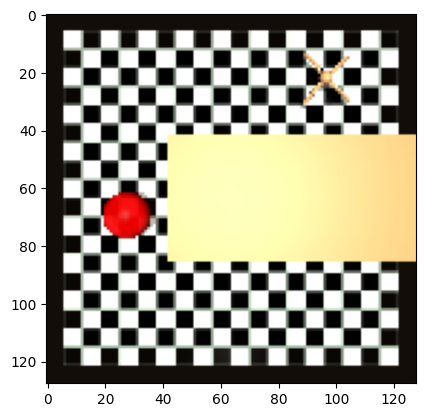

In [29]:


# カスタム迷路を指定
custom_map = [
    [1, 1, 1, 1, 1],
    [1, 0, 0, 0, 1],
    [1, 0, 1, 1, 1],
    [1, 0, 0, 0, 1],
    [1, 1, 1, 1, 1],
]

# custom_map = [
#     [1, 1, 1, 1, 1, 1, 1],
#     [1, 0, 0, 1, 0, 0, 1],
#     [1, 1, 0, 1, 1, 0, 1],
#     [1, 0, 0, 0, 1, 0, 1],
#     [1, 0, 1, 0, 0, 0, 1],
#     [1, 0, 1, 1, 1, 0, 1],
#     [1, 1, 1, 1, 1, 1, 1],
# ]

env = AntMazeEnv(maze_type='UMaze', maze_map=custom_map, max_episode_steps=1000, seed=42)


obs = env.reset()


action = env.action_space.sample()
obs, reward, done, info = env.step(action)

# 画像を確認
import matplotlib.pyplot as plt
plt.imshow(obs)
plt.show()

env.close()


Original obs shape: (128, 128, 3) dtype: uint8 min: 0 max: 255


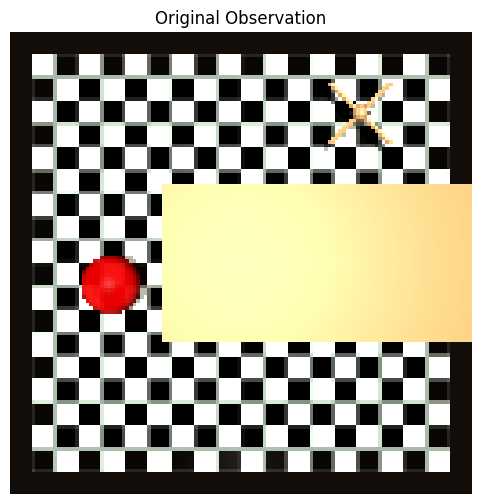

Original obs shape: (128, 128, 3) dtype: uint8 min: 0 max: 255
Original obs shape: (128, 128, 3) dtype: uint8 min: 0 max: 255
Original obs shape: (128, 128, 3) dtype: uint8 min: 0 max: 255
Original obs shape: (128, 128, 3) dtype: uint8 min: 0 max: 255
Original obs shape: (128, 128, 3) dtype: uint8 min: 0 max: 255
Original obs shape: (128, 128, 3) dtype: uint8 min: 0 max: 255
Original obs shape: (128, 128, 3) dtype: uint8 min: 0 max: 255
Original obs shape: (128, 128, 3) dtype: uint8 min: 0 max: 255
Original obs shape: (128, 128, 3) dtype: uint8 min: 0 max: 255
Original obs shape: (128, 128, 3) dtype: uint8 min: 0 max: 255


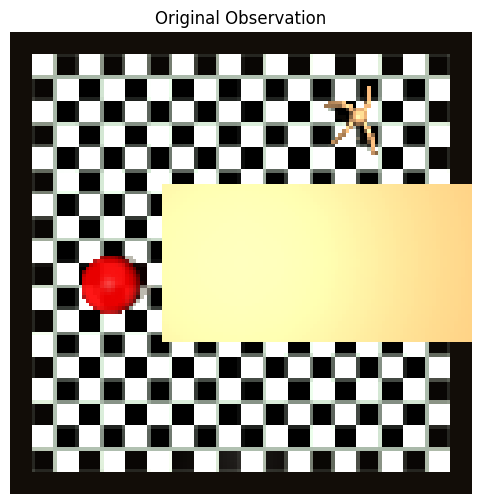

Original obs shape: (128, 128, 3) dtype: uint8 min: 0 max: 255
Original obs shape: (128, 128, 3) dtype: uint8 min: 0 max: 255
Original obs shape: (128, 128, 3) dtype: uint8 min: 0 max: 255
Original obs shape: (128, 128, 3) dtype: uint8 min: 0 max: 255
Original obs shape: (128, 128, 3) dtype: uint8 min: 0 max: 255
Original obs shape: (128, 128, 3) dtype: uint8 min: 0 max: 255
Original obs shape: (128, 128, 3) dtype: uint8 min: 0 max: 255
Original obs shape: (128, 128, 3) dtype: uint8 min: 0 max: 255
Original obs shape: (128, 128, 3) dtype: uint8 min: 0 max: 255
Original obs shape: (128, 128, 3) dtype: uint8 min: 0 max: 255


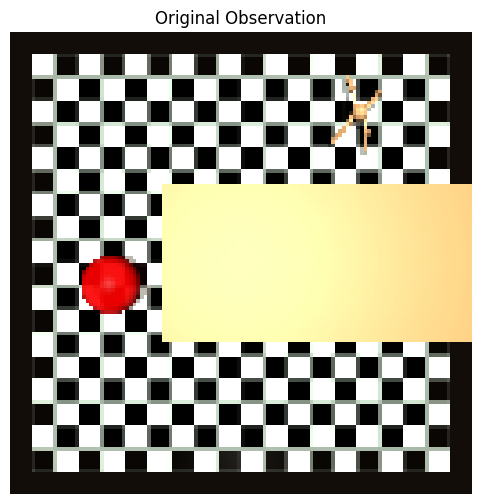

Original obs shape: (128, 128, 3) dtype: uint8 min: 0 max: 255
Original obs shape: (128, 128, 3) dtype: uint8 min: 0 max: 255
Original obs shape: (128, 128, 3) dtype: uint8 min: 0 max: 255
Original obs shape: (128, 128, 3) dtype: uint8 min: 0 max: 255
Original obs shape: (128, 128, 3) dtype: uint8 min: 0 max: 255
Original obs shape: (128, 128, 3) dtype: uint8 min: 0 max: 255
Original obs shape: (128, 128, 3) dtype: uint8 min: 0 max: 255
Original obs shape: (128, 128, 3) dtype: uint8 min: 0 max: 255
Original obs shape: (128, 128, 3) dtype: uint8 min: 0 max: 255
Original obs shape: (128, 128, 3) dtype: uint8 min: 0 max: 255


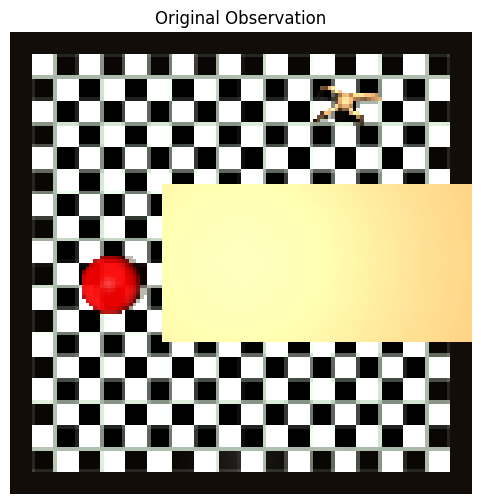

Original obs shape: (128, 128, 3) dtype: uint8 min: 0 max: 255
Original obs shape: (128, 128, 3) dtype: uint8 min: 0 max: 255
Original obs shape: (128, 128, 3) dtype: uint8 min: 0 max: 255
Original obs shape: (128, 128, 3) dtype: uint8 min: 0 max: 255
Original obs shape: (128, 128, 3) dtype: uint8 min: 0 max: 255
Original obs shape: (128, 128, 3) dtype: uint8 min: 0 max: 255
Original obs shape: (128, 128, 3) dtype: uint8 min: 0 max: 255
Original obs shape: (128, 128, 3) dtype: uint8 min: 0 max: 255
Original obs shape: (128, 128, 3) dtype: uint8 min: 0 max: 255
Original obs shape: (128, 128, 3) dtype: uint8 min: 0 max: 255


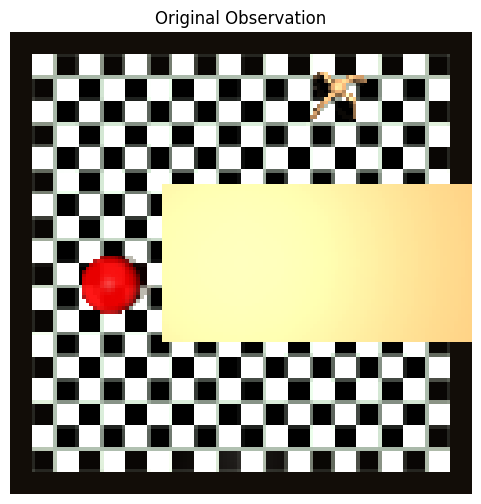

Original obs shape: (128, 128, 3) dtype: uint8 min: 0 max: 255
Original obs shape: (128, 128, 3) dtype: uint8 min: 0 max: 255
Original obs shape: (128, 128, 3) dtype: uint8 min: 0 max: 255
Original obs shape: (128, 128, 3) dtype: uint8 min: 0 max: 255
Original obs shape: (128, 128, 3) dtype: uint8 min: 0 max: 255
Original obs shape: (128, 128, 3) dtype: uint8 min: 0 max: 255
Original obs shape: (128, 128, 3) dtype: uint8 min: 0 max: 255
Original obs shape: (128, 128, 3) dtype: uint8 min: 0 max: 255
Original obs shape: (128, 128, 3) dtype: uint8 min: 0 max: 255
Original obs shape: (128, 128, 3) dtype: uint8 min: 0 max: 255


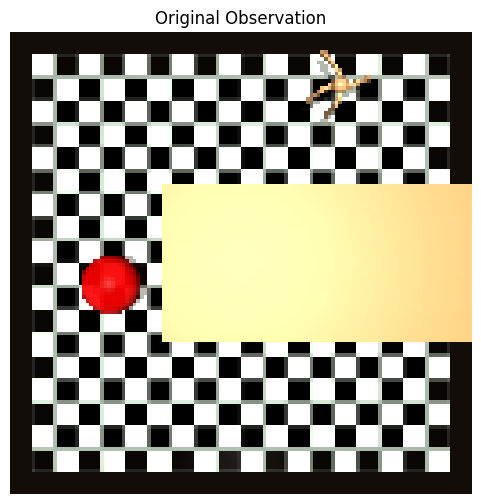

Original obs shape: (128, 128, 3) dtype: uint8 min: 0 max: 255
Original obs shape: (128, 128, 3) dtype: uint8 min: 0 max: 255
Original obs shape: (128, 128, 3) dtype: uint8 min: 0 max: 255
Original obs shape: (128, 128, 3) dtype: uint8 min: 0 max: 255
Original obs shape: (128, 128, 3) dtype: uint8 min: 0 max: 255
Original obs shape: (128, 128, 3) dtype: uint8 min: 0 max: 255
Original obs shape: (128, 128, 3) dtype: uint8 min: 0 max: 255
Original obs shape: (128, 128, 3) dtype: uint8 min: 0 max: 255
Original obs shape: (128, 128, 3) dtype: uint8 min: 0 max: 255
Original obs shape: (128, 128, 3) dtype: uint8 min: 0 max: 255


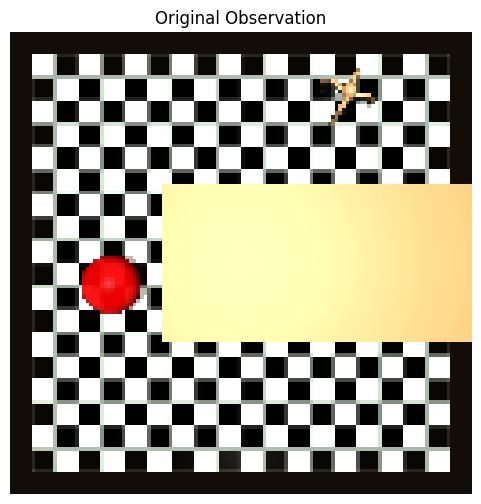

Original obs shape: (128, 128, 3) dtype: uint8 min: 0 max: 255
Original obs shape: (128, 128, 3) dtype: uint8 min: 0 max: 255


Exception ignored on calling ctypes callback function: <function _handle_glfw_errors at 0x7d4597afe4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/glfw/__init__.py", line 662, in callback_wrapper
    @functools.wraps(func)
KeyboardInterrupt: 


Original obs shape: (128, 128, 3) dtype: uint8 min: 0 max: 255


/usr/local/lib/python3.10/dist-packages/glfw/__init__.py:917: GLFWError: (65537) b'The GLFW library is not initialized'
  warnings.warn(message, GLFWError)


RuntimeError: Rendering error: Default framebuffer is not complete, error 0x0

In [30]:
import sys
from pathlib import Path
from omegaconf import OmegaConf
import numpy as np
import torch
from tqdm import tqdm

import logging

# ログの設定
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(message)s",
    handlers=[
        logging.StreamHandler(sys.stdout)
    ]
)

logger = logging.getLogger(__name__)

# from config import Config
# from lexa import LEXA
# from envs.franka_kitchen import FrankaKichenEnv
# from replay_buffer import ReplayBuffer
# from utils import fix_seed, preprocess_obs

base_path = "/output"

config_dict = {
    'model': {
        'world_model': {
            'emb_dim': 1024,
            'z_dim': 32,
            'num_classes': 32,
            'h_dim': 600,
            'hidden_dim': 600,
            'num_layers_za2hidden': 1,
            'num_layers_h2z': 1,
            'mlp_hidden_dim': 400,
            'min_std': 0.1,
            'kl_balance_alpha': 0.8,
            'kl_loss_scale': 0.1,
        },
        'explorer': {
            'num_emsembles': 10,
            'emsembles_offset': 1,
            'emsembles_target_mode': 'z',
            'mlp_hidden_dim': 400,
            'min_std': 0.1,
            'discount': 0.99,
            'lambda_': 0.95,
            'actor_entropy_scale': 0.0001,
            'slow_critic_update': 100,
        },
        'achiever': {
            'num_positives': 256,
            'neg_sampling_factor': 0.1,
            'mlp_hidden_dim': 400,
            'min_std': 0.1,
            'discount': 0.99,
            'lambda_': 0.95,
            'actor_entropy_scale': 0.0001,
            'slow_critic_update': 100,
        }
    },
    'env': {
        'task': 'FrankaKitchen-v1',
        'img_size': 128,
        'action_repeat': 2,
        'time_limit': 1000,
    },
    'data': {
        'buffer_size': 200,
        'batch_size': 50,
        'seq_length': 50,
        'imagination_horizon': 15,
    },
    'learning': {
        'seed_steps': 5000,
        'num_steps': 200,
        'expl_episode_freq': 2,
        'world_model_lr': 0.0002,
        'explorer_actor_lr': 0.00004,
        'explorer_critic_lr': 0.0001,
        'achiever_actor_lr': 0.00004,
        'achiever_critic_lr': 0.0001,
        'epsilon': 0.00001,
        'weight_decay': 0.000001,
        'grad_clip': 100,
        'update_freq': 4,
        'eval_episode_freq': 5,
    },
    'wandb': {
        'logging': False,
        'name': 'lexa',
        'group': '',
        'project': 'LEXA',
    },
    'device': 'cuda',
    'seed': 0,
}

def main(cfg):
    logger.info("Initializing configuration and environment...")
    cfg = Config(**cfg)
    fix_seed(cfg.seed)

    # env = FrankaKichenEnv(cfg.env.img_size, cfg.env.action_repeat, cfg.env.time_limit, cfg.seed)
    # eval_env = FrankaKichenEnv(cfg.env.img_size, cfg.env.action_repeat, cfg.env.time_limit, cfg.seed)


    env = AntMazeEnv(maze_type='UMaze', maze_map=custom_map, max_episode_steps=1000, seed=42)
    eval_env = AntMazeEnv(maze_type='UMaze', maze_map=custom_map, max_episode_steps=1000, seed=42)

    logger.info("Environment initialized. Setting up LEXA and replay buffer...")
    lexa = LEXA(cfg, env)
    replay_buffer = ReplayBuffer(cfg.data.buffer_size,
                                 (3, cfg.env.img_size, cfg.env.img_size),
                                 env.action_space.shape[0])

    obs = env.reset()
    logger.info("Starting seed steps...")

    # seed steps
    for step in range(cfg.learning.seed_steps):
        action = env.action_space.sample()
        next_obs, reward, done, info = env.step(action)
        print("Original obs shape:", obs.shape, "dtype:", obs.dtype, "min:", obs.min(), "max:", obs.max())


        # 画像を表示 (必要に応じて一定間隔で表示)

        if step % 10 == 0:
            plt.figure(figsize=(6, 6))
            plt.imshow(obs)
            plt.title("Original Observation")
            plt.axis("off")
            plt.show()

        replay_buffer.push(preprocess_obs(obs), action, done)
        obs = next_obs
        if done:
            obs = env.reset()
        if step % 1000 == 0:
            logger.info(f"Completed {step} seed steps.")

    logger.info("Seed steps completed. Starting learning steps...")

    # learning steps
    obs = env.reset()
    goal = None
    episodes = 0
    best_score = -1
    for step in tqdm(range(cfg.learning.num_steps)):
        with torch.no_grad():
            if episodes % cfg.learning.expl_episode_freq == 0:
                mode = 'explorer'
            else:
                mode = 'achiever'

            action = lexa.agent(preprocess_obs(obs), mode, goal)
            next_obs, reward, done, info = env.step(action)
            replay_buffer.push(preprocess_obs(obs), action, done)
            obs = next_obs

        if (step + 1) % cfg.learning.update_freq:
            logger.debug("Updating model...")
            observations, actions, done_flags = replay_buffer.sample(cfg.data.batch_size, cfg.data.seq_length)
            metrics = lexa.train(observations, actions)

        if (step + 1) % cfg.model.explorer.slow_critic_update:
            lexa.explorer.update_critic()
        if (step + 1) % cfg.model.achiever.slow_critic_update:
            lexa.achiever.update_critic()

        if done:
            logger.info(f"Steps: {step + 1}, Episode: {episodes}, Metrics: {metrics}")
            lexa.save(base_path / cfg.wandb.name / f'{step + 1}')
            episodes += 1
            obs = env.reset()
            lexa.agent.reset()
            goal, _, _ = replay_buffer.sample(1, 1)
            goal = goal.squeeze(1)
            if episodes % cfg.learning.eval_episode_freq:
                logger.info("Evaluating agent...")
                with torch.no_grad():
                    success = 0
                    for goal_idx in eval_env.goals:
                        eval_obs = eval_env.reset()
                        eval_env.set_goal_idx(goal_idx)
                        goal_obs = eval_env.get_goal_obs()
                        eval_done = False
                        while not eval_done:
                            eval_action = lexa.agent(preprocess_obs(eval_obs), 'achiever', preprocess_obs(goal_obs), train=False)
                            eval_obs, eval_reward, eval_done, eval_info = eval_env.step(eval_action)
                        if eval_env.compute_success():
                            success += 1
                    score = success / len(eval_env.goals)
                logger.info(f"Steps: {step + 1}, Episode: {episodes}, Eval Score: {score}")
                if score > best_score:
                    best_score = score
                    lexa.save(base_path / cfg.wandb.name / 'best')
                lexa.agent.reset()

if __name__ == '__main__':
    logger.info("Starting training script...")
    cfg = OmegaConf.create(config_dict)
    main(cfg)
